In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

General outlook: 

* Current season and historical scoring -> swarm plot of points at each game

    * Distribution of points from locations compared with those other top scorers (2pt/3pt/FT)
    
    * Compare how many field goals which he made were assisted/unassisted with this year/historic players
    
    * Compare free throw shooting with other players.
    
    * Step backs comparison (like with Doncic)
    
    * Step backs shot chart
    
    * Shotchart for this year
    
        
* Evolution of Harden

    * Shotchart through time would be nice to see
    
    * How his usage rose through time
    
    * Change in style from OKC to HOU
    
    
* Comparsion with Phoenix' system with D'Antoni

    * Compare Harden with Steve Nash
    
    * Shot charts comparison

## Setup

In [2]:
from nba_api.stats.static.players import find_players_by_full_name

In [3]:
harden_data = find_players_by_full_name("James Harden")

In [4]:
harden_id = harden_data[0]['id']

## Analyzing shooting splits

In [14]:
import time

In [5]:
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits

In [11]:
int_seasons = list(range(2009, 2019))

In [32]:
harden_shot_types_df = None
harden_overall_df = None
seasons = list()
for i in range(len(int_seasons)):
    season_str = str(int_seasons[i]) + "-" + str(int_seasons[i]+1)[-2:]
    data_frames = PlayerDashboardByShootingSplits(
            player_id=harden_id,
            season=season_str).get_data_frames()
    shot_type_detail = data_frames[-2]
    shot_type_detail.loc[:, 'SEASON'] = season_str
    overall = data_frames[0]
    overall.loc[:, 'SEASON'] = season_str
    time.sleep(1)
    if harden_shot_types_df is None:
        harden_shot_types_df = shot_type_detail
        harden_overall_df = overall
    else:
        harden_shot_types_df = harden_shot_types_df.append(shot_type_detail, ignore_index=True)
        harden_overall_df = harden_overall_df.append(overall, ignore_index=True)

In [44]:
step_backs = harden_shot_types_df.loc[harden_shot_types_df.GROUP_VALUE == 'Step Back Jump shot']

In [40]:
plt.style.use('seaborn')

In [48]:
step_backs.FGA.tolist()

[2, 15, 17, 70, 147, 191, 199, 155, 267, 375]

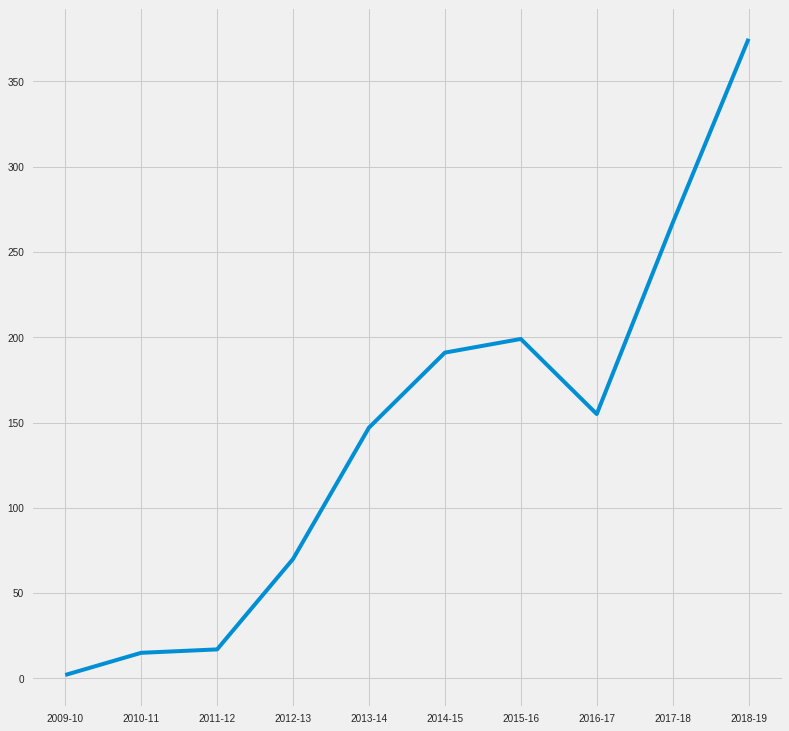

In [64]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot('SEASON', 'FGA', data=step_backs)


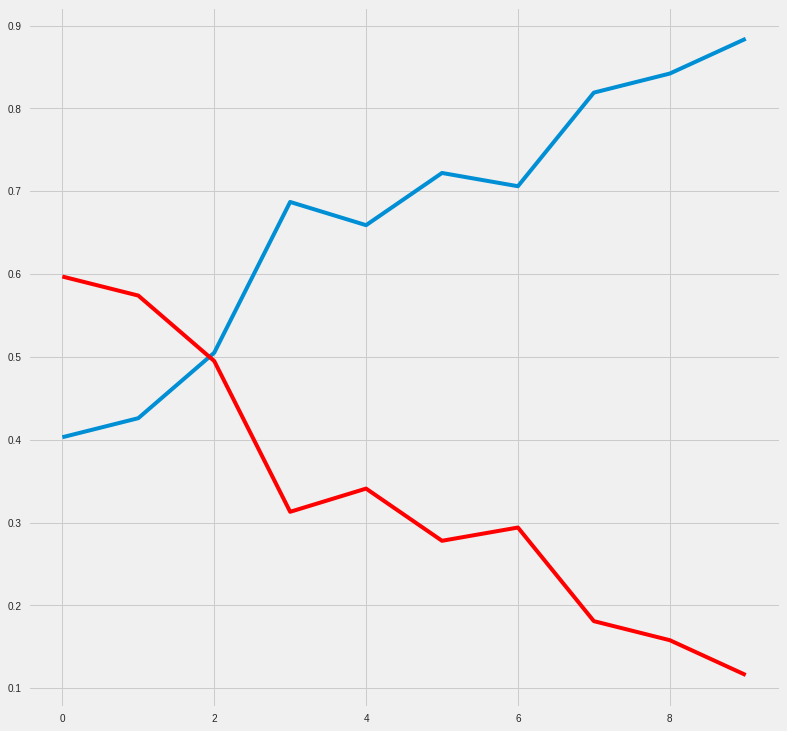

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(harden_overall_df.PCT_UAST_FGM)
ax.plot(harden_overall_df.PCT_AST_FGM, color='r')

## Comparison with historic top scorers

In [5]:
import requests
from bs4 import BeautifulSoup

In [7]:
def get_urls_for_top_scorers(url):
    res = requests.get(top_scorers_url)
    soup = BeautifulSoup(res.text)
    item = soup.find(attrs={'class': 'stats_table'})
    rows = item.findAll("tr")
    urls = list()
    for row in rows:
        header_cells = row.findAll("th")
        for header_cell in header_cells:
            if 'data-stat' in header_cell.attrs and header_cell['data-stat'] == 'ranker' and 'csk' in header_cell.attrs:
                rank = int(header_cell.getText())
        td_cells = row.findAll("td")
        if not td_cells:
            continue
        for cell in td_cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'season':
                season = int(cell.getText().split("-")[0])+1
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'player':
                url = cell.findAll("a")[0]['href']
        game_log_url = bbref_base + url.split(".")[0] + "/gamelog/" + str(season)
        urls.append(game_log_url)
    return urls

In [25]:
import re

def get_player_name_points(url, limit):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    title = soup.find('h1').getText()
    splitted = re.split('\d{4}-\d{2}', title)
    name = splitted[0].strip()
    dash_splitted = title.split('-')
    season = dash_splitted[0].split(" ")[-1] + "-" + dash_splitted[1].split(" ")[0]
    player_names = list()
    seasons = list() # this will be filled with same values
    points = list()
    
    rows = soup.findAll('tr')
    for row in rows:
        cells = row.findAll('td')
        for cell in cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'reason':
                continue
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'game_season':
                if cell.getText() == "":
                    continue
                if int(cell.getText()) > limit:
                    break
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'pts':
                points.append(int(cell.getText()))
                player_names.append(name)
                seasons.append(season)
    
    return player_names, seasons, points

In [12]:
url = 'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019'
names, seasons, points = get_player_name_points(url)

In [20]:
top_scorers_urls = [
    'https://www.basketball-reference.com/players/j/jordami01/gamelog/1987',
    'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019',
    'https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006',
    'https://www.basketball-reference.com/players/i/iversal01/gamelog/2006',
    'https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003',
    'https://www.basketball-reference.com/players/d/duranke01/gamelog/2014',
    'https://www.basketball-reference.com/players/w/westbru01/gamelog/2017',
    'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006',
]

In [29]:
import time
full_names, full_seasons, full_points = [], [], []
harden_total_games = 51
for url in top_scorers_urls:
    print(f"Current url: {url}")
    names, seasons, points = get_player_name_points(url, limit=harden_total_games)
    time.sleep(0.5)
    full_names.extend(names)
    full_seasons.extend(seasons)
    full_points.extend(points)

data_frame = pd.DataFrame(data={
    'PLAYER': full_names,
    'SEASON': full_seasons,
    'POINTS': full_points
})

Current url: https://www.basketball-reference.com/players/j/jordami01/gamelog/1987
Current url: https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019
Current url: https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006
Current url: https://www.basketball-reference.com/players/i/iversal01/gamelog/2006
Current url: https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003
Current url: https://www.basketball-reference.com/players/d/duranke01/gamelog/2014
Current url: https://www.basketball-reference.com/players/w/westbru01/gamelog/2017
Current url: https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006


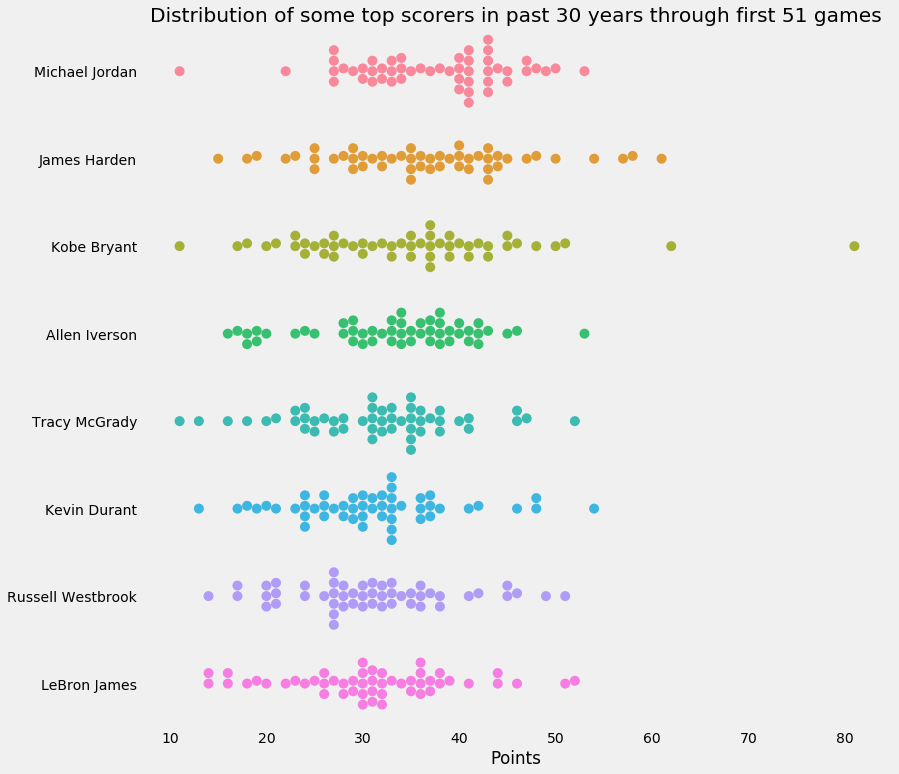

In [59]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.swarmplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax, size=10)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')

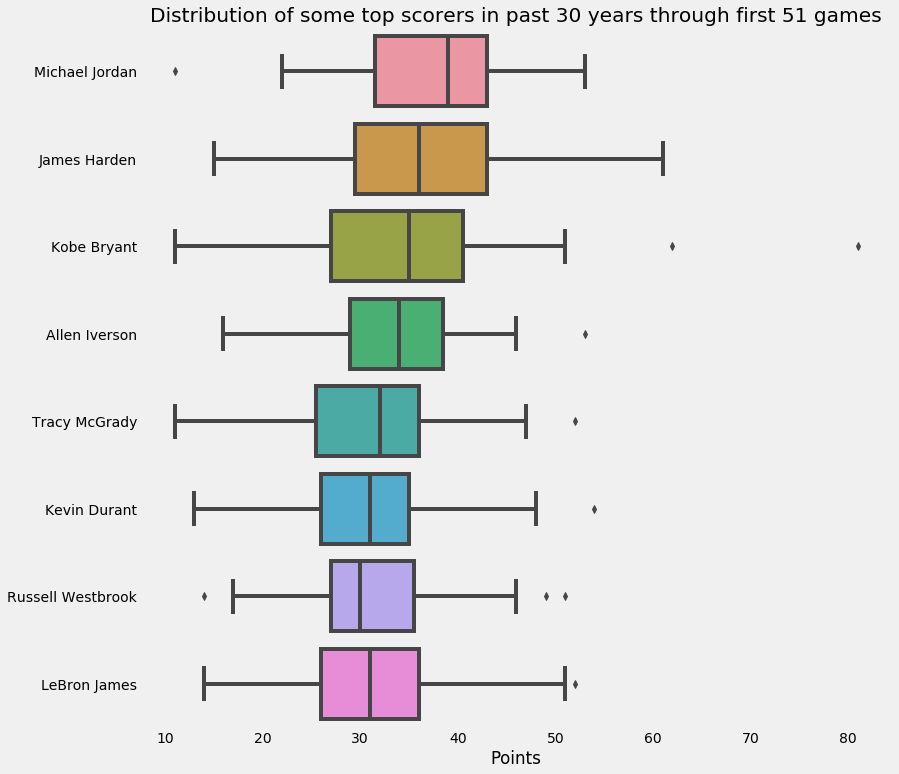

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')